In [25]:
from google.colab import files
uploaded = files.upload()


In [33]:
import pandas as pd

df = pd.read_csv('data.csv', encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Data Cleaning

In [27]:
df.dropna(subset=['CustomerID'], inplace=True)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True, errors='coerce')
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

<ipython-input-27-2020473761>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True, errors='coerce')
<ipython-input-27-2020473761>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


RFM Analysis

In [28]:
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,NaN,1,77183.60
1,12347.0,96.0,7,4310.00
2,12348.0,221.0,4,1797.24
3,12349.0,NaN,1,1757.55
4,12350.0,312.0,1,334.40


Normalize the RFM Data

In [29]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Optional: reduce skew in monetary
rfm['Monetary'] = np.log1p(rfm['Monetary'])

# Normalize
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

Cluster with KMeans
a. Use Elbow Method to find optimal k

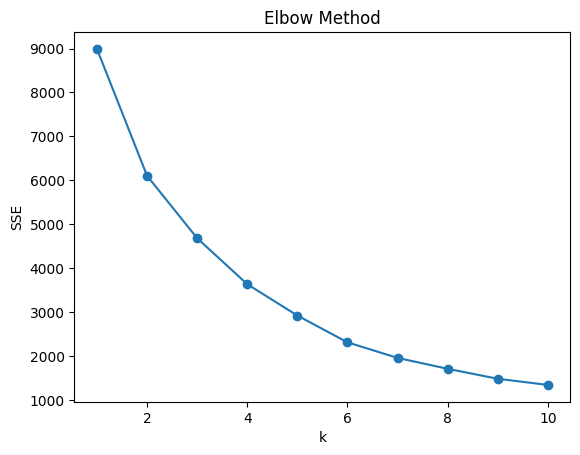

In [30]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Drop rows with any missing values
rfm.dropna(inplace=True)

# Optional: remove customers with zero Frequency or Monetary
rfm = rfm[(rfm['Frequency'] > 0) & (rfm['Monetary'] > 0)]
# Re-scale
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()


b. Apply KMeans

In [31]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,Cluster
1,12347.0,96.0,7,8.368925,0
2,12348.0,221.0,4,7.494564,0
4,12350.0,312.0,1,5.815324,3
5,12352.0,275.0,8,7.826858,0
8,12355.0,97.0,1,6.132096,3


Visualize the Clusters

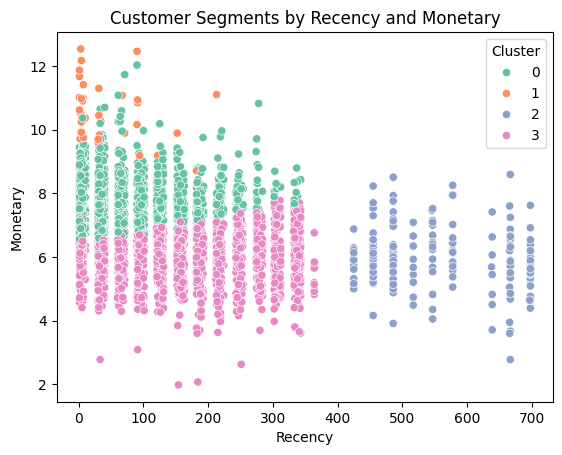

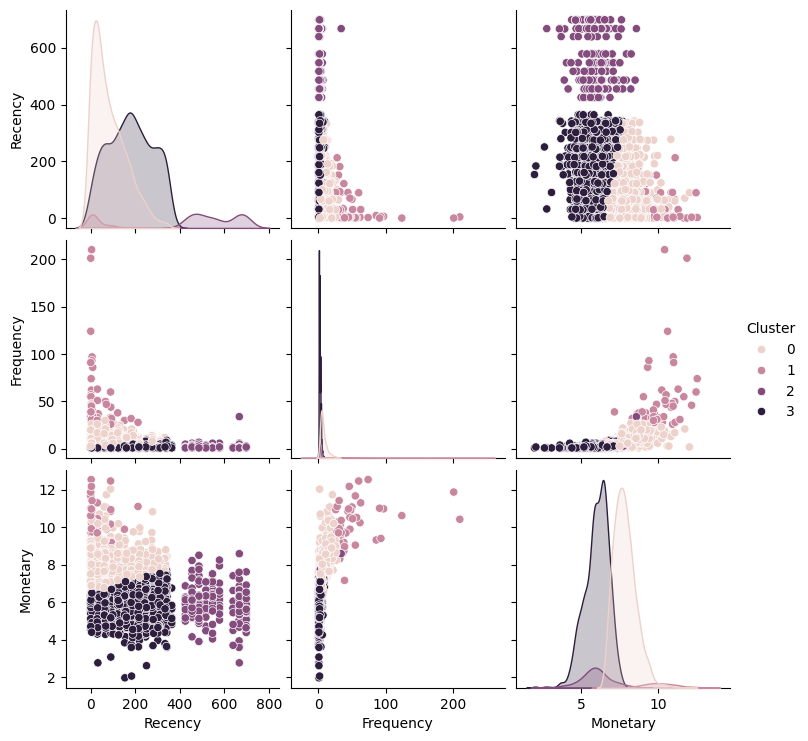

In [32]:
import seaborn as sns

# 2D Scatter
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2')
plt.title('Customer Segments by Recency and Monetary')
plt.show()

# Pairplot
sns.pairplot(rfm, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'])
